In [1]:
from PIL import Image
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.distance import cdist
import random
from scipy import rand

# PCA & LDA

In [2]:
TARGET_SIZE = [50, 50]
SUBJECT = 11

## Load pgm data

In [3]:
def load_data(dataset):
    train_file_list = os.listdir(os.path.join(dataset, 'Training'))
    test_file_list = os.listdir(os.path.join(dataset, 'Testing'))
    
    dic_list_train = []
    dic_list_test = []

    for file in train_file_list:
        image = Image.open(os.path.join(dataset, 'Training', file))
        image = image.resize(TARGET_SIZE)
        label = int(re.findall(r'subject(\d+)', file)[0])
        tmp_dic = {'image' : np.reshape(np.asarray(image), -1) , 'label' : label}
        dic_list_train.append(tmp_dic)
    
    for file in test_file_list:
        image = Image.open(os.path.join(dataset, 'Testing', file))
        image = image.resize(TARGET_SIZE)
        label = int(re.findall(r'subject(\d+)', file)[0])
        tmp_dic = {'image' : np.reshape(np.asarray(image), -1) , 'label' : label}
        dic_list_test.append(tmp_dic)
    
    return dic_list_train, dic_list_test

In [4]:
train_data_list, test_data_list = load_data('Yale_Face_Database')

In [5]:
X_train = np.array([dic['image'] for dic in train_data_list])
y_train = np.array([dic['label'] for dic in train_data_list])
X_test = np.array([dic['image'] for dic in test_data_list])
y_test = np.array([dic['label'] for dic in test_data_list])
all_data = np.concatenate((X_train, X_test), axis=0)
all_label = np.concatenate((y_train, y_test), axis=0)
all_data = all_data.astype('float64')

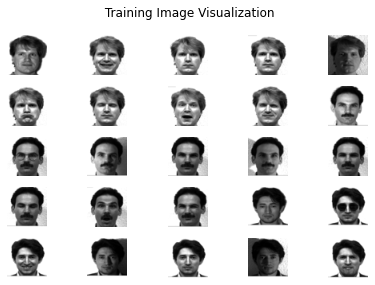

In [6]:
plt.suptitle(' Training Image Visualization')
for idx, dic in enumerate(train_data_list):
    if idx>24:
        break
    image = dic['image'].reshape((50, 50))
    label = dic['label']
    plt.subplot(5,5,idx+1)
    plt.imshow(image, cmap='gray'), plt.axis('off')
plt.tight_layout()
plt.show()

# PCA & kernel PCA

We want to find an orthogonal projection $W$ in which the data $x$ after projection $z = Wx$ will have maximum variance, i,e minimum mean square error(MSE).

### In common PCA

$\mathop{\arg\max}\limits_{w^1}Var(z_1)=\frac{1}{N}\sum_{z_1}(z_1 - z_2 )^2 = (w^1)^T [\frac{1}{N}\sum_{x}(x-\bar{x})(x-\bar{x})^{T}](w^1)$<br>
where $ S = [\frac{1}{N}\sum_{x}(x-\bar{x})(x-\bar{x})^{T}]$ is covariance matrix!<br>
$S$ symmetric and PSD, optimal with $w^1$ the eigenvector related to maximum eigenvalue!<br>
Orthogonal projection $W$ is composed of $k$ first largest eigenvectors of covariance matrix of $x$ (principal components)

### In kernel PCA 

The main differences between kernel PCA and PCA is that we do the projection in feature space.<br>
This is the non-linear extension of PCA.<br>
Notice that, we was assuming data in feature space are centered already.<br>
$K^C = K - 1_NK - K1_N + 1_NK1_N$ where $1_N$ is a $N*N$ matrix for which each element takes value $1/N$

In [7]:
def PCA(X, k=25):
    x_bar = np.mean(X, axis=0)
    x_meaned = X-x_bar
    cov = np.cov(x_meaned, rowvar=False)
    eigen_val, eigen_vec = np.linalg.eigh(cov)
    idx = eigen_val.argsort()[::-1]
    W = eigen_vec[:, idx][:, :k]
    projection_z = X@W
    return projection_z, W

In [8]:
def kernel_PCA(X, kernel_type='linear', k=25):
    K = get_kernel(X, kernel_type)
    n = K.shape[0]
    one = np.ones((n, n), dtype=np.float64) / n
    K_c = K - one@K - K@one + one@K@one

    eigen_val, eigen_vec = np.linalg.eigh(K_c)
    idx = eigen_val.argsort()[::-1]
    W = eigen_vec[:, idx][:, :k]
    projection_z = K@W
    return projection_z, W

## LDA & kernel LDA

Since this is a supervised dimensionaltiy reduction, we will have input y in the function.<br>
We want to project data onto a line parameterized by a unit vector $w:y=w^T x$ such that prohected data of $C_1$is maximally separated from projected data of $C_2$ if we use the distance between centers of classes as measure. But in multi-class, we expect that all the class center ($m_1,m_2,...,m_k$) if they are very far away from the overall data mean.  Use this $m$ to define the between class scatter. 

### In common LDA

***Between-class scatter*** : $S_B = \sum_{i=1}^c N_i (m_i - m) (m_i - m)^T$<br>
***Within-class scatter*** : $S_W = \sum_{i=1}^c \sum_{x_j \in X_c} (x_j - m_i) (x_j - m_i)^T$<br>
where $m$ is the overall data center, and $m_i$ is the center of each class $i$<br>
Then get first $q$ largest **eigenvectors** of $S_{W}^{-1}S_{B}$ as $W$

### In kernel LDA

Instead of original data, we compute the within-classes scatter $N$ and between-classes scatter $M$ with the kernel matrix.<br>
$M = \sum_{m=1}^c l_m (M_m - M_*)(M_m - M_*)^T \\ N = \sum_{m=1}^c K_m(I - 1_{l_m})K_m^T$ <br>
$(M_m)_i = {1 \over l_m} \sum_{k=1}^{m_j} k(x_j, x_i^k) $<br> 
$(M_*)j = {1 \over n} \sum_{i=1}^n k(x_j, x_i) \\ (K_m)_{ij} = k(x_i, x_j^{k=m})$<br>
Project data by solving eigen problem:<br>
$N^{-1}M \alpha_i = \lambda_i \alpha_i$
reference paper : https://www.csie.ntu.edu.tw/~mhyang/papers/fg02.pdf

In [9]:
def compute_mean(X, y):
    data_m = np.mean(X, axis=0)
    n_classes = len(np.unique(y))
    n_features = X.shape[1]
    class_m = np.zeros((n_classes, n_features))

    for i in range(X.shape[0]): # image num
        for j in range(n_features): # pixel num
            class_m[y[i]-1][j] += X[i][j]
    for i in range(n_classes):
        for j in range(n_features):
            class_m[i][j] /= SUBJECT

    return class_m, data_m

def compute_betweenclass(class_m, data_m):
    n_features = data_m.shape[0]
    n_classes = class_m.shape[0]
    S_B = np.zeros((n_features, n_features))
    for i in range(n_classes):
        dist = np.subtract(class_m[i], data_m[i]).reshape(n_features, 1)
        S_B += np.matmul(dist, dist.T)
    S_B *= SUBJECT

    return S_B

def compute_withinclass(X, y, class_m):
    n_features = X.shape[1]
    S_W = np.zeros((n_features, n_features))
    for i in range(X.shape[0]):
        dist = np.subtract(X[i], class_m[y[i]-1]).reshape(n_features, 1)
        S_W += np.matmul(dist, dist.T)
    return S_W

In [10]:
def LDA(X, y, k=25):
    class_m, data_m = compute_mean(X, y)
    S_B = compute_betweenclass(class_m, data_m)
    S_W = compute_withinclass(X, y, class_m)
    trace = np.linalg.pinv(S_W)@S_B 
    eigen_val, eigen_vec = np.linalg.eigh(trace)
    idx = eigen_val.argsort()[::-1]
    W = eigen_vec[:, idx][:, :k]
    projection_z = X@W
    return projection_z, W

In [11]:
def kernel_LDA(X, y, kernel_type='linear',  k=25):
    K = get_kernel(X, kernel_type)
    M = np.zeros([X.shape[0], X.shape[0]])
    for i in range(15):
        classM = K[np.where(y == i+1)[0]].copy()
        classM = np.sum(classM, axis=0).reshape(-1, 1) / SUBJECT
        allM = K[np.where(y == i+1)[0]].copy()
        allM = np.sum(allM, axis=0).reshape(-1, 1) / X.shape[0]
        dist = np.subtract(classM, allM)
        multiplydist = SUBJECT * np.matmul(dist, dist.T)
        M += multiplydist

    N = np.zeros([X.shape[0], X.shape[0]])
    I_minus_one = np.identity(SUBJECT) - (SUBJECT * np.ones((SUBJECT, SUBJECT)))
    for i in range(15):
        Kj = K[np.where(y == i+1)[0]].copy()
        multiply = np.matmul(Kj.T, np.matmul(I_minus_one, Kj))
        N += multiply

    eigen_val, eigen_vec = np.linalg.eigh(np.linalg.pinv(N)@M)
    idx = eigen_val.argsort()[::-1]
    W = eigen_vec[:, idx][:, :k]
    projection_z = K@W

    return projection_z, W

### select kernel

In [12]:
def get_kernel(X, type):
    if type == 'linear':
        return X @ X.T
    elif type == 'poly':
        gamma = 5
        coef = 50
        degree = 2
        return np.power(gamma * (X @ X.T) + coef, degree)
    elif type == 'rbf':
        gamma = 1e-7
        return np.exp(-gamma * scipy.spatial.distance.cdist(X, X, 'sqeuclidean'))

# Part1:  

**Use PCA and LDA to show the first 25 eigenfaces and fisherfaces, and randomly pick 10 images to show their reconstruction.**<br> 

In [13]:
def visualization_eigen(W, k=25):
    plt.suptitle(' Eigenface')
    for idx, eigen in enumerate(W.T):
        if idx>24:
            break
        image = eigen.reshape((50, 50))
        plt.subplot(5,5,idx+1)
        plt.imshow(image, cmap='gray'), plt.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
def visualization_reconstruct(z, W):
    plt.suptitle(' Reconstruction')
    reconstruction = z@W.T
    # show random 10 pics
    rand_reconstruction = random.sample(reconstruction.tolist(), 10)
    for idx, data in enumerate(rand_reconstruction):
        if idx>9:
            break
        image = np.asarray(data)
        image = image.reshape(TARGET_SIZE)
        plt.subplot(1,10,idx+1)
        #plt.suptitle('reconstruction' + str(idx))
        plt.imshow(image, cmap='gray'), plt.axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
z, W = PCA(all_data, k=25)
z_2, W_2 = LDA(all_data, all_label, k=25)

## Eigenface and Reconstruction in PCA

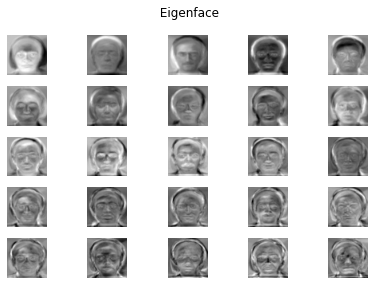

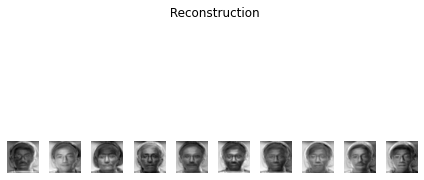

In [16]:
visualization_eigen(W, k=25)
visualization_reconstruct(z, W)

## Fisher's face and Reconstruction in LDA

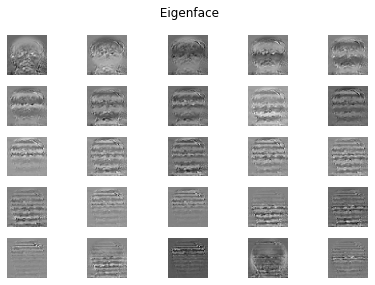

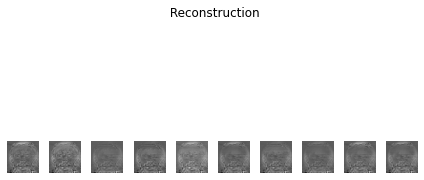

In [17]:
visualization_eigen(W_2, k=25)
visualization_reconstruct(z_2, W_2)

# Part2

**Use PCA and LDA to do face recognition, and compute the performance. You should use k nearest neighbor to classify which subject the testing image belongs to.**<br>

In [18]:
def KNN(X_train, y_train, X_test, y_test, method, kernel=None):
    trainsize = X_train.shape[0]
    testsize = X_test.shape[0]
    result = np.zeros(testsize)
    for testidx in range(testsize):
        alldist = np.zeros(trainsize)
        for trainidx in range(trainsize):
            alldist[trainidx] = np.sqrt(np.sum((X_test[testidx] - X_train[trainidx]) ** 2))
        result[testidx] = y_train[np.argmin(alldist)]
    # acc
    correct = 0
    for i in range(len(X_test)):
        if y_test[i] == result[i]:
            correct += 1
    print(f'{method} with kernel {kernel} Accuracy : {correct}/{len(y_test)}')

In [19]:
z_test = z[135:].copy()
z_train = z[:135].copy()
z2_test = z_2[135:].copy()
z2_train = z_2[:135].copy()
KNN(z_train, y_train, z_test, y_test, 'PCA')
KNN(z2_train, y_train, z2_test, y_test, 'LDA')

PCA with kernel None Accuracy : 25/30
LDA with kernel None Accuracy : 25/30


# Part3

**Use kernel PCA and kernel LDA to do face recognition, and compute the performance. (You can choose whatever kernel you want, but you should try different kernels in your implementation.) Then compare the difference between simple LDA/PCA and kernel LDA/PCA, and the difference between different kernels.**

In [20]:
for kernel_type in ['linear', 'poly', 'rbf']:
    z, W = kernel_PCA(X=all_data, kernel_type=kernel_type, k=25)
    KNN(X_train=z[:135], y_train=y_train, X_test=z[135:], y_test=y_test, method='PCA', kernel=kernel_type)
    z2, W2 = kernel_LDA(X=all_data, y=all_label, kernel_type=kernel_type, k=25)
    KNN(X_train=z2[:135], y_train=y_train, X_test=z2[135:], y_test=y_test, method='LDA', kernel=kernel_type)

PCA with kernel linear Accuracy : 24/30
LDA with kernel linear Accuracy : 23/30
PCA with kernel poly Accuracy : 24/30
LDA with kernel poly Accuracy : 23/30
PCA with kernel rbf Accuracy : 25/30
LDA with kernel rbf Accuracy : 24/30
